# Image Colorization using Transfer Learning

This notebook outlines steps to develop a image colorization network based on a 3 component network consisting of an Encoder, a Fusion Layer and a Decoder. The network utilizes VGG16 as a feature extractor to its benefit. The implementation is based on the works of Baldassarre et al.

The network is a result of creatively utilizing alternate colorspaces like LAB and YUV instead of the regular RGB colorspace. The following image showcases how different colorspaces represent the same image across different channels.

<img src="colorspaces.png">


Utilizing a colorspace such as LAB, the advantage is due to the fact that one of the channels is the grayscale channel itself. Thus the coloring task is transformed into a task of mapping the grayscale pixel values to pixel values in channels __a__ and __b__ , as shown in the following image.

<img src="colorization_task.png" style="height:250px;">


The network expects a grayscale input image transformed from RGB to LAB colorspace. We also perform a few more preprocessing steps to enable the network to learn the task. The overall network architecture is as shown in the following image.
<img src="colornet_architecture.png" style="height:300px;">

In [ ]:
from google.colab import files

In [ ]:
import os
import random
import numpy as np

import scipy as sp
import scipy.ndimage as spi

from skimage.io import imsave,imshow
from skimage.transform import resize
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [1]:
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from keras.engine import Layer
from keras.layers import Reshape, merge, concatenate
from keras.layers import Input,Activation, Dense, Dropout, Flatten
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose 

from keras.layers.core import RepeatVector, Permute
from keras.layers.normalization import BatchNormalization

from keras.callbacks import TensorBoard 

from keras.models import Sequential, Model

import tensorflow as tf

Using TensorFlow backend.


## Load the sample dataset
We utilize a small subset of images from the ImageNet Dataset

In [0]:
def upload_files():
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

In [3]:
file_list = upload_files()

Saving 0dc3e95a9954c5d50e5ddac5bf774e09.jpeg to 0dc3e95a9954c5d50e5ddac5bf774e09.jpeg
Saving 1b99b787ef471af6c652e01737d883a6.jpeg to 1b99b787ef471af6c652e01737d883a6.jpeg
Saving 1cc416b4897eca408ad396a09ad000cd.jpeg to 1cc416b4897eca408ad396a09ad000cd.jpeg
Saving 2fbb562e61f6460cf9820940d61b7001.jpeg to 2fbb562e61f6460cf9820940d61b7001.jpeg
Saving 3b8640a78d79be87f927a63174902346.jpeg to 3b8640a78d79be87f927a63174902346.jpeg
Saving 5a2987b714c15456c0e038dabcf426e2.jpeg to 5a2987b714c15456c0e038dabcf426e2.jpeg
Saving 5a0728978e9a5180076ec357bc28c92e.jpeg to 5a0728978e9a5180076ec357bc28c92e.jpeg
Saving 6a47074ff275acedfa82ffbc9025b703.jpeg to 6a47074ff275acedfa82ffbc9025b703.jpeg
Saving 6b85128b02f95c628c85437b1eef38a4.jpeg to 6b85128b02f95c628c85437b1eef38a4.jpeg
Saving 6d905979f4788767939883c0f8b4250b.jpeg to 6d905979f4788767939883c0f8b4250b.jpeg
Saving 07c4859f54fb3184aebca9a7b3aa5317.jpeg to 07c4859f54fb3184aebca9a7b3aa5317.jpeg
Saving 7a24ba5bfdbb9602f78197e3e103feb4.jpeg to 7a24ba

## Preprocess

Input images are resized and pixel values are brought within the 24bit RGB range

In [0]:
def prep_data(file_list=[],
              dir_path=None,
              dim_x=256,
              dim_y=256):
    #Get images
    X = []
    for filename in file_list:
        X.append(img_to_array(
            sp.misc.imresize(
                load_img(
                    dir_path+filename),
                    (dim_x, dim_y))
            )
        )
    X = np.array(X, dtype=np.float64)
    X = 1.0/255*X
    return X

## load pretrained VGG16

In [5]:
#Load weights
vgg16 = VGG16(weights=r'imagenet', include_top=True)
vgg16.graph = tf.get_default_graph()

553467904/553467096 [==============================] - 34s 0us/step


In [6]:
vgg16.output_shape

(None, 1000)

## Prepare Train and Test Datasets

In [7]:
train_files,test_files =train_test_split(file_list, 
                                            test_size=0.3,  
                                            random_state=42)
len(train_files),len(test_files)

(31, 14)

In [0]:
DIM = 256

In [9]:
X_train = prep_data(file_list=train_files,
                    dir_path='',
                    dim_x=DIM,dim_y=DIM)

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


## Construct the network

As mentioned earlier, the network has a unique architecture consisting of the following components:
+ Encoder
+ Feature Extractor
+ Fusion Layer
+ Decoder

In [0]:
emd_input = Input(shape=(1000,))

#Encoder
enc_input = Input(shape=(DIM, DIM, 1,))
enc_output = Conv2D(64, (3,3), 
                        activation='relu', 
                        padding='same', strides=2)(enc_input)
enc_output = Conv2D(128, (3,3), 
                        activation='relu', 
                        padding='same')(enc_output)
enc_output = Conv2D(128, (3,3), 
                        activation='relu', 
                        padding='same', strides=2)(enc_output)
enc_output = Conv2D(256, (3,3), 
                        activation='relu', 
                        padding='same')(enc_output)
enc_output = Conv2D(256, (3,3), 
                        activation='relu', 
                        padding='same', strides=2)(enc_output)
enc_output = Conv2D(512, (3,3), 
                        activation='relu', 
                        padding='same')(enc_output)
enc_output = Conv2D(512, (3,3), 
                        activation='relu', 
                        padding='same')(enc_output)
enc_output = Conv2D(256, (3,3), 
                        activation='relu', 
                        padding='same')(enc_output)

#Fusion
fusion_layer_output = RepeatVector(32*32)(emd_input) 
fusion_layer_output = Reshape(([32,32, 
                          1000]))(fusion_layer_output)
fusion_layer_output = concatenate([enc_output, 
                                   fusion_layer_output], axis=3) 
fusion_layer_output = Conv2D(DIM, (1, 1), 
                       activation='relu', 
                       padding='same')(fusion_layer_output) 

#Decoder
dec_output = Conv2D(128, (3,3), 
                        activation='relu', 
                        padding='same')(fusion_layer_output)
dec_output = UpSampling2D((2, 2))(dec_output)
dec_output = Conv2D(64, (3,3), 
                        activation='relu', 
                        padding='same')(dec_output)
dec_output = UpSampling2D((2, 2))(dec_output)
dec_output = Conv2D(32, (3,3), 
                        activation='relu', 
                        padding='same')(dec_output)
dec_output = Conv2D(16, (3,3), 
                        activation='relu', 
                        padding='same')(dec_output)
dec_output = Conv2D(2, (3, 3), 
                        activation='tanh', 
                        padding='same')(dec_output)
dec_output = UpSampling2D((2, 2))(dec_output)

model = Model(inputs=[enc_input, emd_input], outputs=dec_output)

## Feature Extraction and Image Augmentation

VGG16 is used as feature extractor. We also utilize data augmentation to help our model generalize better.

In [0]:
#Create embedding
def create_vgg_embedding(grayscaled_rgb):
    gs_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (224, 224, 3), 
                   mode='constant')
        gs_rgb_resized.append(i)
    gs_rgb_resized = np.array(gs_rgb_resized)
    gs_rgb_resized = preprocess_input(gs_rgb_resized)
    with vgg16.graph.as_default():
      embedding = vgg16.predict(gs_rgb_resized)
    return embedding

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

def colornet_img_generator(X,
                  batch_size=BATCH_SIZE):
    for batch in datagen.flow(X, batch_size=batch_size):
        gs_rgb = gray2rgb(rgb2gray(batch))
        batch_lab = rgb2lab(batch)
        
        batch_l = batch_lab[:,:,:,0]
        batch_l = batch_l.reshape(batch_l.shape+(1,))
        
        batch_ab = batch_lab[:,:,:,1:] / 128
        yield ([batch_l, 
                create_vgg_embedding(gs_rgb)], batch_ab)

## Train the Model

In [0]:
model.compile(optimizer='adam', loss='mse')

In [0]:
#Generate training data
BATCH_SIZE = 64
EPOCH=800
STEPS_PER_EPOCH = 2

In [15]:
history = model.fit_generator(colornet_img_generator(X_train,
                                                     BATCH_SIZE), 
                              epochs=EPOCH, 
                              steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/800
2/2 [==============================] - 16s 8s/step - loss: 0.3072
Epoch 2/800
2/2 [==============================] - 2s 1s/step - loss: 0.0530
Epoch 3/800
2/2 [==============================] - 5s 3s/step - loss: 0.0179
Epoch 4/800
2/2 [==============================] - 5s 3s/step - loss: 0.0197
Epoch 5/800
2/2 [==============================] - 5s 3s/step - loss: 0.0188
Epoch 6/800
2/2 [==============================] - 5s 3s/step - loss: 0.0183
Epoch 7/800
2/2 [==============================] - 5s 3s/step - loss: 0.0179
Epoch 8/800
2/2 [==============================] - 5s 3s/step - loss: 0.0176
Epoch 9/800
2/2 [==============================] - 5s 3s/step - loss: 0.0171
Epoch 10/800
2/2 [==============================] - 5s 3s/step - loss: 0.0169
Epoch 11/800
2/2 [==============================] - 5s 3s/step - loss: 0.0165
Epoch 12/800
2/2 [==============================] - 5s 3s/step - loss: 0.0167
Epoch 13/800
2/2 [==============================] - 5s 3s/step - loss: 0

In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 128 73856       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 128)  147584      conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

## Analyze Model Performance

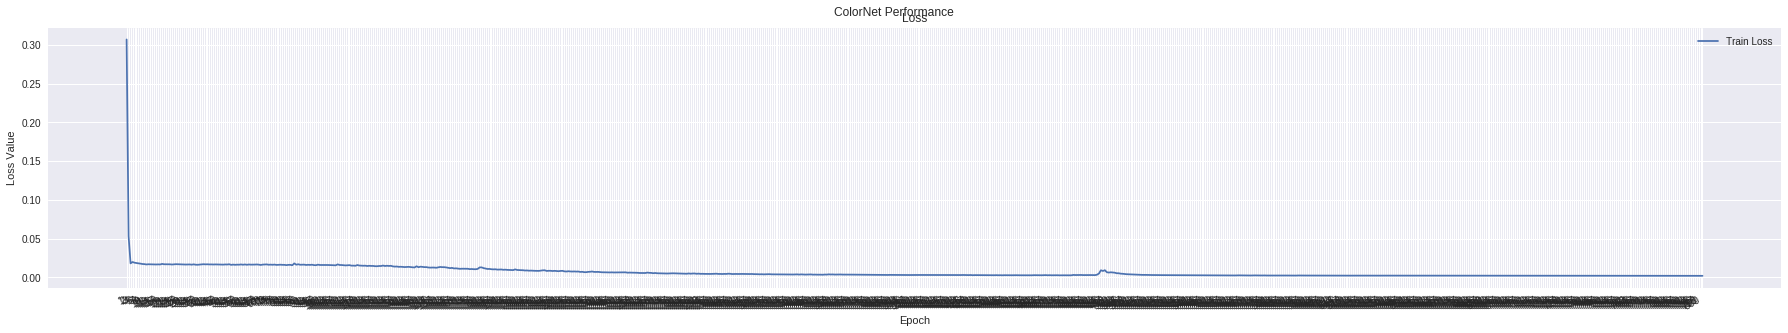

In [17]:
f, (ax2) = plt.subplots(1, 1, figsize=(25, 5))
t = f.suptitle('ColorNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCH+1))

ax2.plot(epochs, history.history['loss'], label='Train Loss')
#ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

plt.tight_layout()
f.autofmt_xdate()
plt.show()

## Test Data

Visualize the hallucinated output on the test dataset to understand how well the model has learnt the image colorization task

In [18]:
#Make predictions on validation images

IMG_DIR = ''
sample_img = []
for filename in test_files:
    sample_img.append(sp.misc.imresize(load_img(IMG_DIR+filename), 
                                     (DIM, DIM)))
sample_img = np.array(sample_img, 
                    dtype=float)
sample_img = 1.0/255*sample_img
sample_img = gray2rgb(rgb2gray(sample_img))

sample_img = rgb2lab(sample_img)[:,:,:,0]
sample_img = sample_img.reshape(sample_img.shape+(1,))

#embedding input
sample_img_embed = create_vgg_embedding(sample_img)

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [0]:
# Test model
output_img = model.predict([sample_img, sample_img_embed])
output_img = output_img * 128

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


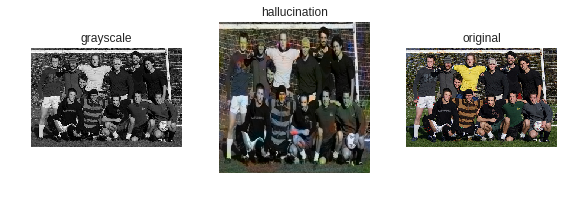

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 4 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


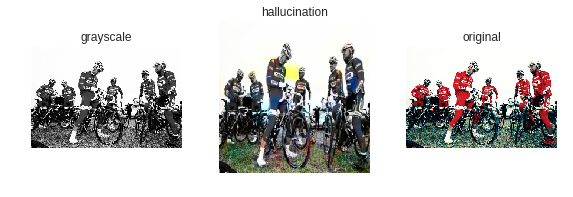

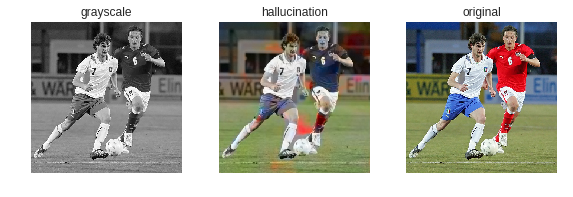

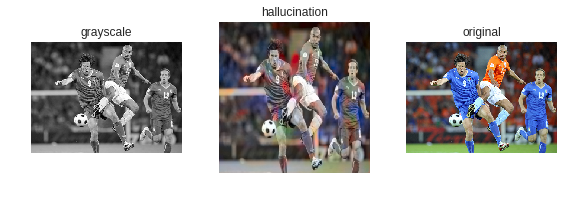

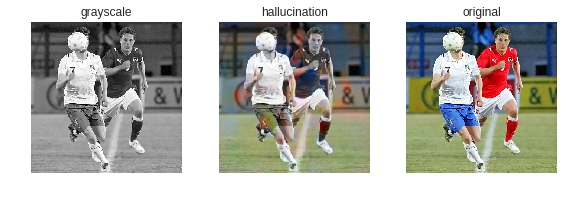

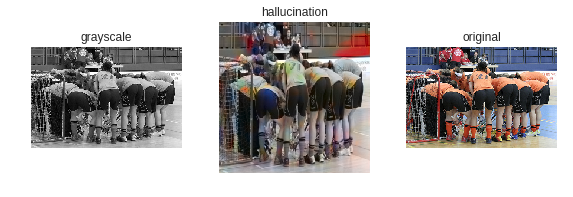

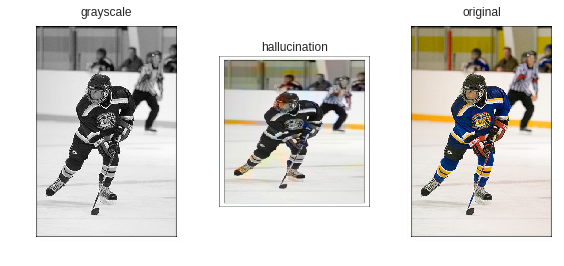

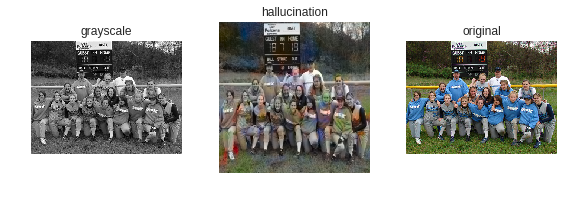

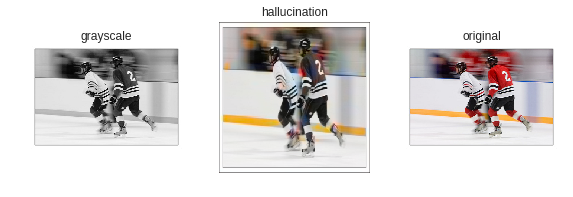

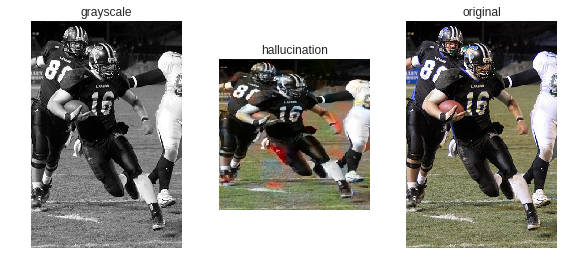

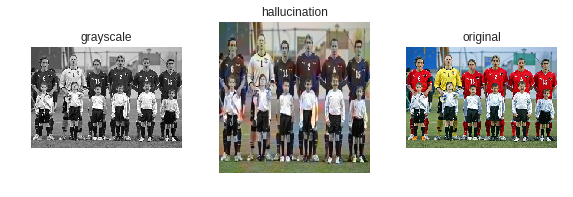

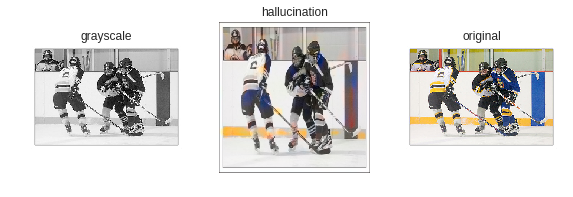

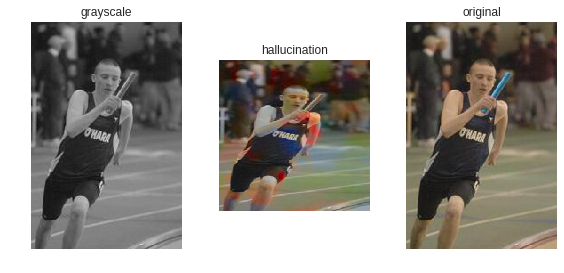

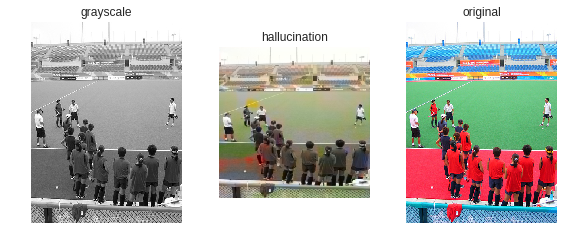

In [23]:
filenames = test_files
# Output colorizations
for i in range(len(output_img)):
    fig = plt.figure(figsize=(8,8))
    final_img = np.zeros((DIM,DIM, 3))
    
    # add grayscale channel
    final_img[:,:,0] = sample_img[i][:,:,0]
    
    # add predicted channel
    final_img[:,:,1:] = output_img[i]
    
    img_obj = load_img(IMG_DIR+filenames[i])
    
    fig.add_subplot(1, 3, 1)
    plt.axis('off')
    
    grayed_img = gray2rgb(
                  rgb2gray(
                      img_to_array(
                          img_obj)/255)
                  )
    plt.imshow(grayed_img)
    plt.title("grayscale")
    
    fig.add_subplot(1, 3, 2)
    plt.axis('off')
    imshow(lab2rgb(final_img))
    plt.title("hallucination")
    
    fig.add_subplot(1, 3, 3)
    plt.imshow(img_obj)
    plt.title("original")
    plt.axis('off')
    plt.show()